In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import warnings
import random
import pickle
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersistenceImager, PersistenceLandscaper
from scipy.stats import skew, kurtosis
warnings.filterwarnings("ignore")

mother_dir = "/Users/arshaniksa/Desktop/SUT/1403 - 2 - Semester 8/BSc Project/Data/VR Eyes/archive/"
random_state = 42
n_trees = 100
n_points = 10
n_window = 25

os.chdir(mother_dir + "04 Eye Tracking Data/01 Eye Tracking Data (Pre-Processed)/")


gaze_data = []
files = os.listdir()
for file in files:
    if file[-4:] == ".dat":
        datum = []
        with open(file, 'rb') as f:
            data_dict = pickle.load(f)
            labels = data_dict['Labels']
            data = data_dict['Data']
        datum.append(labels)
        datum.append(data)
        gaze_data.append(datum)

reduction_factor = 20
def reduce(trajectory):
    new_traj = []
    i = 0
    while i < np.shape(trajectory)[0]:
        new_traj.append([trajectory[i,0], trajectory[i,1], trajectory[i,2]])
        i += reduction_factor
    trj = np.zeros((len(new_traj), 3))
    for i in range(len(new_traj)):
        trj[i, 0] = new_traj[i][0]
        trj[i, 1] = new_traj[i][1]
        trj[i, 2] = new_traj[i][2]
    return trj

def split_data(data, ratios):
    first_seperator = int(len(data) * ratios[0])
    return (data[0:first_seperator], data[first_seperator:])

flat_gaze = []
for i in range(len(gaze_data)):
    for j in range(12):
        datum = []
        try:
            datum.append(reduce(np.transpose(gaze_data[i][1][j][[1,2,3], :])))
            datum.append(gaze_data[i][0][j][0])
            flat_gaze.append(datum)
        except:
            continue
random.Random(random_state).shuffle(flat_gaze)

ratios = [0.8, 0.2]
train_data, exam_data = split_data(flat_gaze, ratios)

In [2]:
os.chdir(mother_dir + "04 Eye Tracking Data/02 Eye Tracking Data (Features Extracted)/")
df_ml = pd.read_csv('EyeTracking_FeaturesExtracted.csv')
df_ml

,Quad_Cat,Num_of_Fixations,Mean_Fixation_Duration,SD_Fixation_Duration,Skew_Fixation_Duration,Max_Fixation_Duration,First_Fixation_Duration,Num_of_Saccade,Mean_Saccade_Duration,SD_Saccade_Duration,...,Skew_Microsac_Dir,Max_Microsac_Dir,Mean_Microsac_H_Amp,SD_Microsac_H_Amp,Skew_Microsac_H_Amp,Max_Microsac_H_Amp,Mean_Microsac_V_Amp,SD_Microsac_V_Amp,Skew_Microsac_V_Amp,Max_Microsac_V_Amp
0,1,0.605556,1208.440367,1013.049251,2.080900,6127,1640,0.605556,438.064220,517.053212,...,-0.047816,179.719495,0.419874,25.214209,3.156580,220.069746,-0.182289,8.975206,0.107803,45.070474
1,0,0.459184,1796.311111,1880.259542,2.346293,9773,556,0.448980,392.000000,426.838023,...,-0.161061,179.563907,-4.596920,74.737290,-8.745373,144.173940,0.660248,10.523471,3.971437,81.150671
2,0,0.480000,1617.694444,1895.391401,1.633123,7573,671,0.466667,481.314286,528.473650,...,-0.214484,179.789091,-1.217540,17.351371,-2.922202,35.323715,-1.158868,14.659309,-5.198588,26.595861
3,3,0.454545,1858.763636,2711.244828,3.296111,14840,1804,0.446281,349.240741,427.406260,...,0.083588,179.846777,-0.908321,25.611097,-3.302714,122.294054,0.094660,3.775847,1.529565,29.637883
4,1,0.527778,1582.126316,1520.578818,1.862892,7526,1315,0.522222,311.531915,355.951480,...,0.219166,179.868585,-2.472084,17.046195,-2.911459,55.629425,-0.538492,5.075856,-2.305319,17.997401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,2,0.448276,2023.403846,2121.443120,2.327756,11573,7313,0.439655,222.294118,302.584487,...,0.024436,179.918096,-0.191682,13.274505,0.466416,91.191697,0.023930,2.035751,-0.903471,10.980368
308,0,0.278146,3123.047619,3834.811402,1.773834,17653,6507,0.278146,469.476190,457.909472,...,0.211808,179.990011,1.185974,20.307991,0.029653,96.049968,-0.178666,10.649966,2.409343,64.778420
309,1,0.490683,1419.607595,1361.960488,2.560576,7691,791,0.484472,635.935897,742.269341,...,0.043838,179.540875,-0.217885,17.816587,-2.520313,41.802713,-0.008552,2.974471,1.112915,18.217167
310,3,0.437500,1861.714286,1994.288957,2.229175,10014,1058,0.425000,437.735294,637.969473,...,0.140314,178.757483,0.535478,26.192162,-1.932032,99.197502,-0.047538,9.911744,0.642044,38.135265


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = df_ml.iloc[:, 1:], df_ml.iloc[:, 0]
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print(features_train)
random_forest = RandomForestClassifier(n_estimators=n_trees, random_state=random_state)
random_forest.fit(features_train, labels_train)
rf_pred = random_forest.predict(features_test)
print(accuracy_score(labels_test, rf_pred))

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(labels_test, rf_pred)
matrix.diagonal()/matrix.sum(axis=1)

     Num_of_Fixations  Mean_Fixation_Duration  SD_Fixation_Duration  \
111          0.157025             6104.947368          16404.093650   
208          0.316667             2810.736842           3688.940641   
145          0.438776             1867.930233           2415.526526   
203          0.266667             3389.150000           3877.065022   
78           0.557471             1349.731959           1624.854542   
..                ...                     ...                   ...   
188          0.350993             2434.924528           3351.020171   
71           0.266667             3597.650000           4559.772031   
106          0.387500             1949.161290           5224.796852   
270          0.298851             3019.961538           3281.450074   
102          0.563218             1132.887755           1007.971832   

     Skew_Fixation_Duration  Max_Fixation_Duration  First_Fixation_Duration  \
111                3.284097                  71116                  

array([0.53333333, 0.65217391, 0.46153846, 0.58333333])

Accuracy: 0.571
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.68      0.65      0.67        23
           2       0.43      0.46      0.44        13
           3       0.44      0.58      0.50        12

    accuracy                           0.57        63
   macro avg       0.57      0.56      0.56        63
weighted avg       0.59      0.57      0.58        63



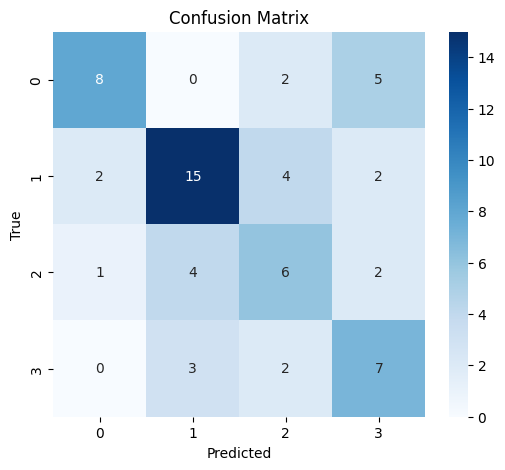

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, predicted_labels, class_names=None, title="Confusion Matrix"):
    test_accuracy = accuracy_score(y_true, predicted_labels)
    report = classification_report(y_true, predicted_labels, target_names=class_names)
    cm = confusion_matrix(y_true, predicted_labels)

    print(f"Accuracy: {test_accuracy:.3f}")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Example usage:
evaluate_model(labels_test, rf_pred, class_names=["0", "1", "2", "3"])
